In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import stable_baselines3 as sb3
import gym
from gym import spaces
import numpy as np

In [2]:
# import datasets
raw_co2 = pd.read_csv("/Users/jaimebustos/Desktop/Yonsei 2024/Deep Learning/Final Project/global_co2_levels.csv", encoding='latin1')
raw_gdp = pd.read_csv("/Users/jaimebustos/Desktop/Yonsei 2024/Deep Learning/Final Project/world_gdp_data.csv", encoding='latin1')

In [3]:
## data preprocessing with gdp growth data

# remove unnecessary column
raw_gdp = raw_gdp.drop("indicator_name", axis=1)

# transpose data to format correct; ensure correct column-wise alignment in future merging with co2
raw_gdp = raw_gdp.transpose()

# drop all countries with NaN data since 1980s
for column in raw_gdp.columns:
    if pd.isna(raw_gdp[column].iloc[1]):
        raw_gdp.drop(column, axis=1, inplace=True)

# reset the index and drop the row with country names
raw_gdp.reset_index(inplace=True)
raw_gdp.drop(0, inplace=True)

# rename the index column to 'year'
raw_gdp.rename(columns={'index': 'year'}, inplace=True)

# set the year as the index
raw_gdp.set_index('year', inplace=True)

# convert the index to integers to ensure proper date-time formatting
raw_gdp.index = raw_gdp.index.astype(int)

# calculate the mean GDP growth values across the resulting countries for each year
raw_gdp['mean_gdp'] = raw_gdp.mean(axis=1)

# keep only the mean GDP values and store into another dataframe variable
gdp = raw_gdp[['mean_gdp']]



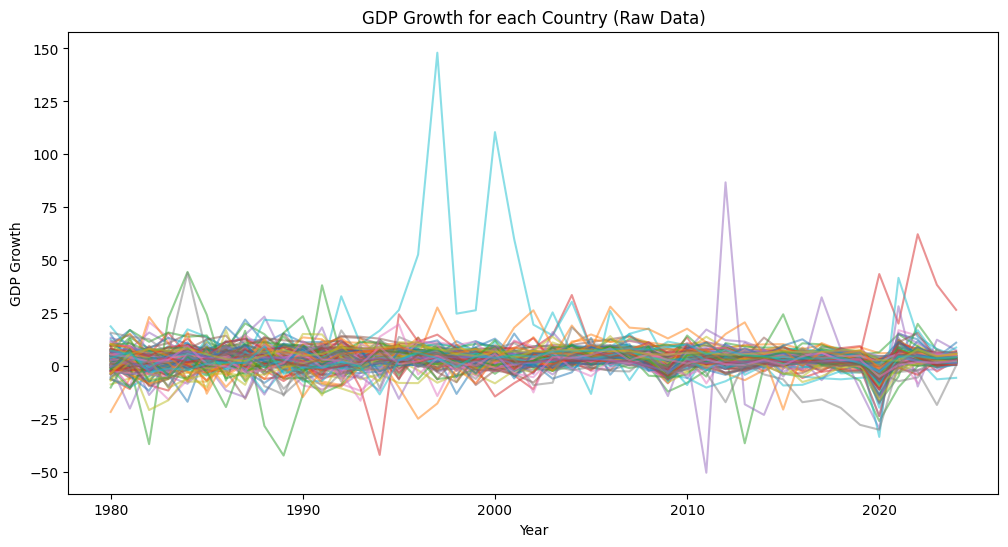

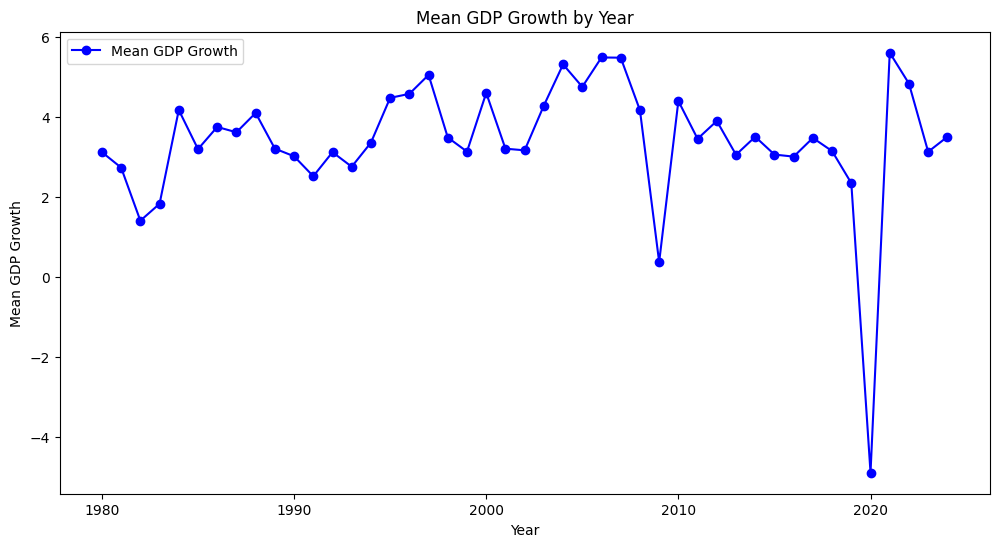

In [4]:
# plot the original GDPs for each country
plt.figure(figsize=(12, 6))
for column in raw_gdp.columns[1:-1]:  # exclude the 'year' and 'mean_gdp' columns
    plt.plot(raw_gdp.index, raw_gdp[column], label=column, alpha=0.5)

plt.xlabel('Year')
plt.ylabel('GDP Growth')
plt.title('GDP Growth for each Country (Raw Data)')
plt.show()

# plot the mean GDP values for each year
plt.figure(figsize=(12, 6))
plt.plot(gdp.index, gdp['mean_gdp'], marker='o', linestyle='-', color='b', label='Mean GDP Growth')
plt.xlabel('Year')
plt.ylabel('Mean GDP Growth')
plt.title('Mean GDP Growth by Year')
plt.legend()
plt.show()

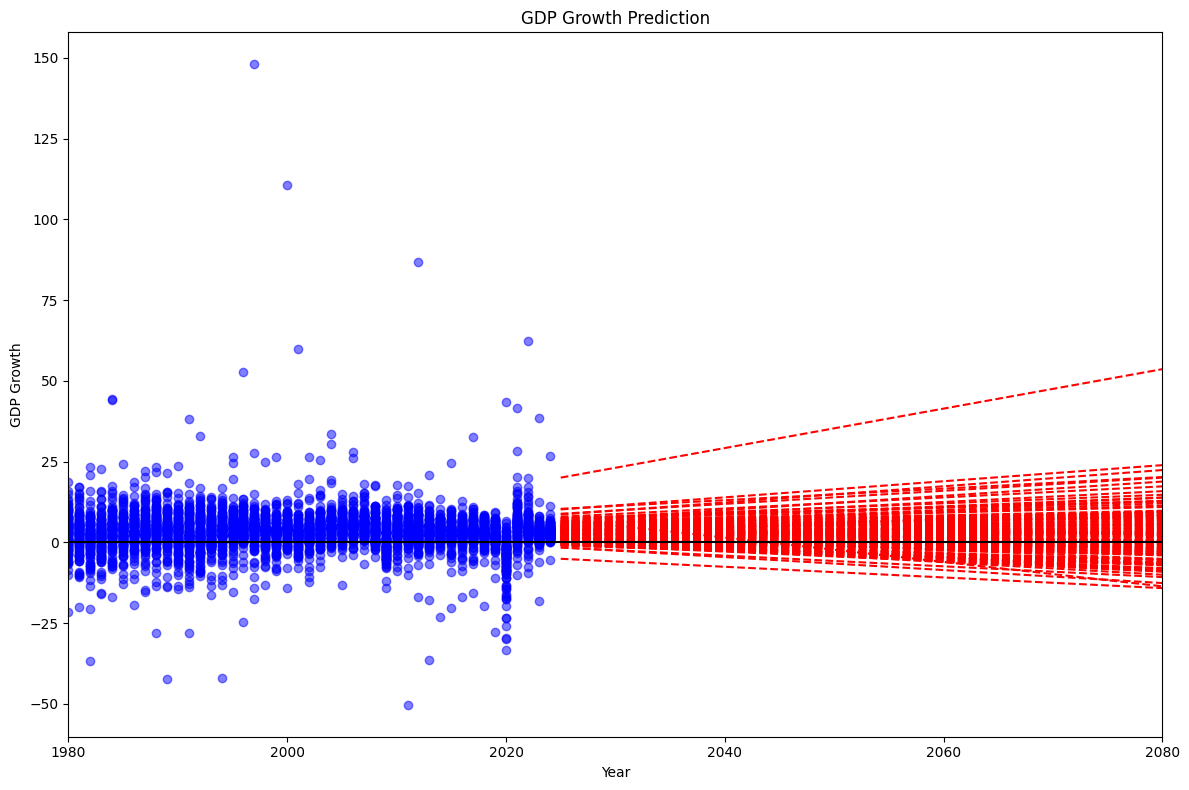

In [5]:
## create linear regression for the future of gdp growth of each country

# fill NaN values with 0 and infer correct types
raw_gdp.fillna(0, inplace=True)
raw_gdp = raw_gdp.infer_objects()

# prepare the input and output data for regression
X = raw_gdp.index.values.reshape(-1, 1)
y = raw_gdp.values

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# predict future mean GDP growth
future_years = np.arange(2025, 2081).reshape(-1, 1)
predictions = model.predict(future_years)

# plot the historical and predicted mean GDP growth
plt.figure(figsize=(12, 8))
for column in raw_gdp.columns:
    plt.scatter(raw_gdp.index, raw_gdp[column], color='blue', alpha=0.5, label='Historical GDP Growth' if column == raw_gdp.columns[0] else "")
plt.plot(future_years, predictions, color='red', linestyle='--', label='Predicted Future Mean GDP Growth')

plt.xlim(1980, 2080) 
plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel('Year')
plt.ylabel('GDP Growth')
plt.title('GDP Growth Prediction')
plt.tight_layout()
plt.show()

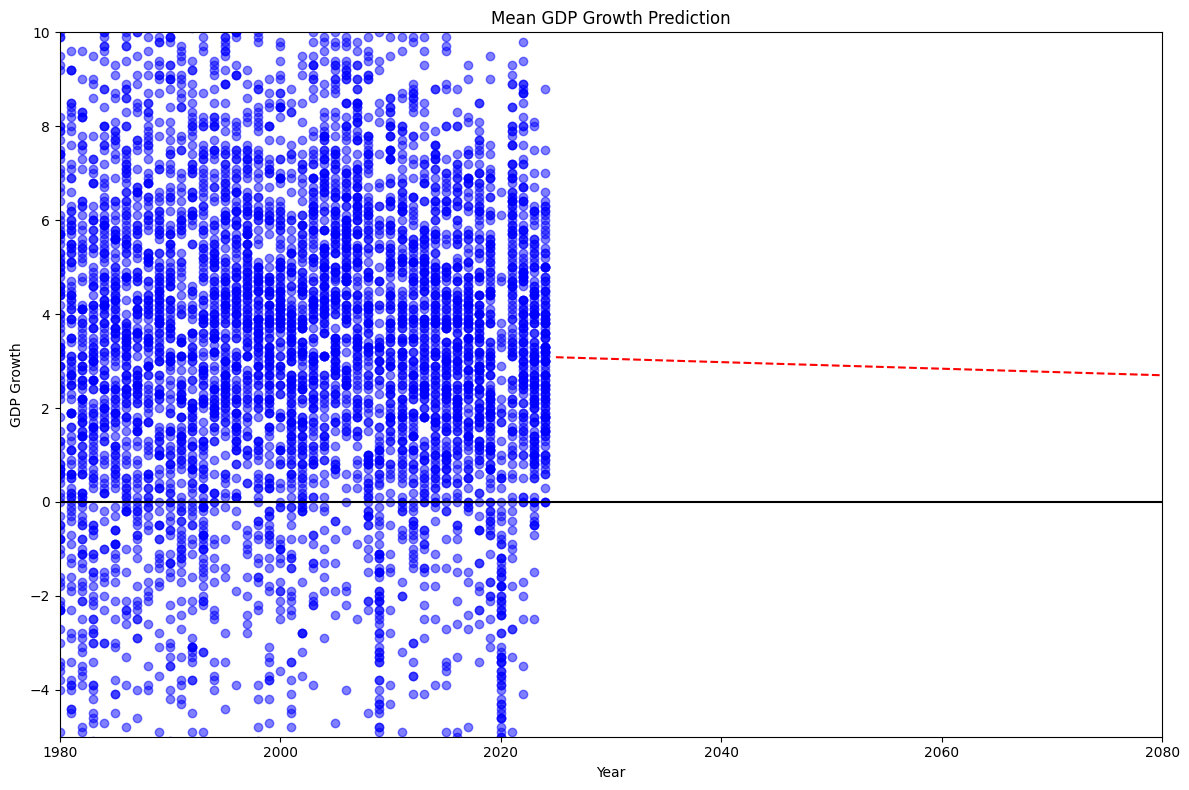

In [6]:
## create linear regression for the future of gdp growth of all the countries using the mean

# prepare the input and output data for regression
X = gdp.index.values.reshape(-1, 1)
y = gdp.values

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# predict future mean GDP growth
future_years = np.arange(2025, 2081).reshape(-1, 1)
predictions = model.predict(future_years)

# plot the historical and predicted mean GDP growth
plt.figure(figsize=(12, 8))
for column in raw_gdp.columns:
    plt.scatter(raw_gdp.index, raw_gdp[column], color='blue', alpha=0.5, label='Historical GDP Growth' if column == raw_gdp.columns[0] else "")
plt.plot(future_years, predictions, color='red', linestyle='--', label='Predicted Future Mean GDP Growth')

plt.xlim(1980, 2080)
plt.ylim(-5, 10)
plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel('Year')
plt.ylabel('GDP Growth')
plt.title('Mean GDP Growth Prediction')
plt.tight_layout()
plt.show()


In [7]:
## data preprocessing with co2 data

# obtain necessary co2 columns
raw_co2 = raw_co2[["Year", "Month", "Carbon Dioxide (ppm)", "Seasonally Adjusted CO2 (ppm)"]]

# combining the year and month into one colum
raw_co2['Date'] = pd.to_datetime(raw_co2[['Year', 'Month']].assign(DAY=1))

# set 'Date' as the index
raw_co2.set_index('Date', inplace=True)

# drop the original 'Year' and 'Month' columns
raw_co2.drop(['Year', 'Month'], axis=1, inplace=True)

# fill the first two rows with the value of 315
raw_co2.iloc[:2] = raw_co2.iloc[:2].fillna(315)

# fill remaining NaN values with the previous value
raw_co2.fillna(method='ffill', inplace=True)

<Axes: xlabel='Date'>

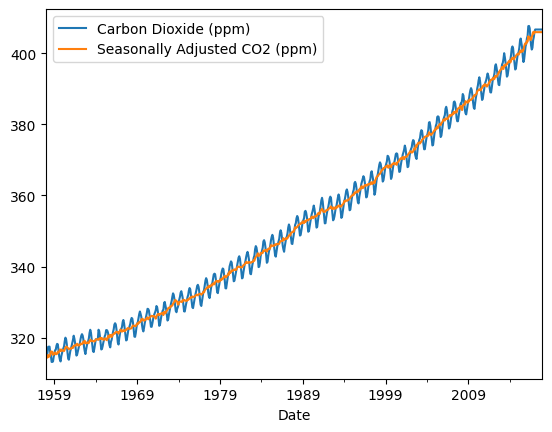

In [8]:
# plot co2 data
raw_co2.plot()

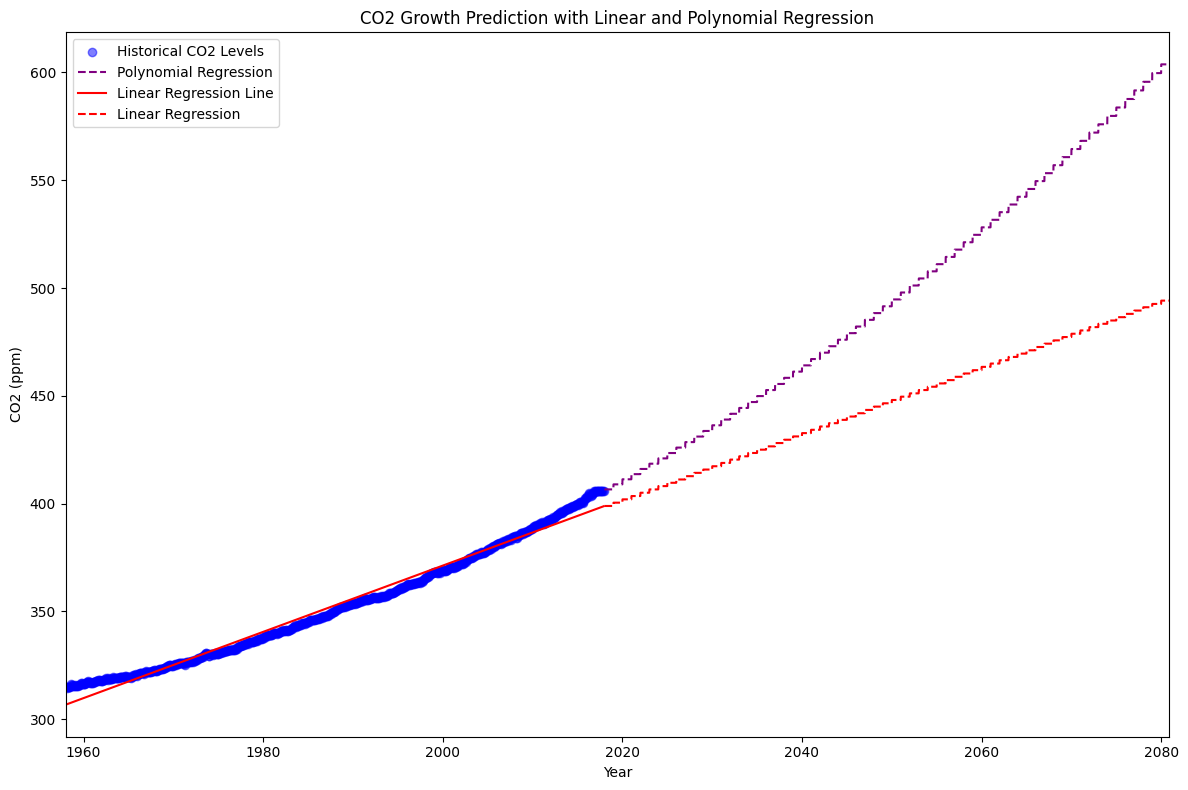

In [9]:
## linear and polynomial regression models for future CO2 levels

# prepare input and output data for regression
X = np.array((raw_co2.index.year + (raw_co2.index.dayofyear / 365.25))).reshape(-1, 1)
y = raw_co2['Seasonally Adjusted CO2 (ppm)'].values

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create and fit the linear regression model
lmodel = LinearRegression()
lmodel.fit(X_train, y_train)

# create and fit the polynomial regression model
poly_degree = 3 
model = make_pipeline(PolynomialFeatures(poly_degree), LinearRegression())
model.fit(X_train, y_train)

# generate future dates
future_dates = pd.date_range(start='2018-01-01', end='2080-12-01')

# convert future dates to years
future_years = np.array([date.year for date in future_dates]).reshape(-1, 1)

# predict future CO2 growth with linear and polynomial
predictions = model.predict(future_years)
lpredictions = lmodel.predict(future_years)
linear_historical_predictions = lmodel.predict(X)

# plot the historical and predicted CO2 growth
plt.figure(figsize=(12, 8))
plt.scatter(raw_co2.index, y, color='blue', alpha=0.5, label='Historical CO2 Levels')
plt.plot(future_dates, predictions, color='purple', linestyle='--', label='Polynomial Regression')
plt.plot(raw_co2.index, linear_historical_predictions, color='red', linestyle='-', label='Linear Regression Line')
plt.plot(future_dates, lpredictions, color='red', linestyle='--', label=f'Linear Regression')

plt.xlim(raw_co2.index.min(), future_dates.max())
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.title('CO2 Growth Prediction with Linear and Polynomial Regression')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
## prepare data for simulation study with reinforcment learning

# convert to yearly data with the average CO2 value
yearly_co2 = raw_co2.resample('Y').mean()

# convert index to year only
yearly_co2.index = yearly_co2.index.year

# rename the index to 'Year'
yearly_co2.index.name = 'Year'

# merging the datasets on 'Year'
merged = pd.concat([yearly_co2, gdp], axis=1)

# drop all NaN values
merged = merged.dropna()

In [11]:
# load all data into data variable
data = {
    'Year': pd.date_range(start='1980', end='2018', freq='Y'),
    'CO2': merged["Seasonally Adjusted CO2 (ppm)"],
    'GDP_Growth': merged["mean_gdp"]
}

data = pd.DataFrame(data).set_index('Year')

# normalize the historical data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
df_normalized = pd.DataFrame(scaled, columns=['CO2', 'GDP_Growth'], index=data.index)

In [12]:
class GDP_CO2_Env(gym.Env):
    def __init__(self, initial_state):
        super(GDP_CO2_Env, self).__init__()
        
        # define action and observation space
        self.action_space = spaces.Discrete(5)  # five actions: no policy change, invest in green tech, implement carbon tax, raise income tax, implement socialist laws
        self.observation_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)  # normalized GDP growth and CO2 levels
        
        # initialize state
        self.initial_state = initial_state
        self.state = initial_state.copy()
        self.co2_history = []
        self.gdp_history = []
        self.cost_history = []
    
    def step(self, action):
        # apply action
        cost = 0
        co2_change = 0
        gdp_change = 0
        if action == 0:
            # no policy change
            co2_change = 0.0001 + np.random.normal(-0.005, 0.005)  # normal increase in CO2
            gdp_change = np.random.normal(-0.009, 0.009)  #  random change to GDP
            cost = 50 + abs(co2_change) * 4  # link cost to the magnitude of CO2 reduction
        elif action == 1:
            # invest in green technology
            co2_change = -0.0005 + np.random.normal(-0.005, 0.005)  # slight decrease in CO2
            gdp_change = 0.0003 + np.random.normal(-0.005, 0.005)  # small increase in GDP
            cost = 80 + abs(gdp_change) * 3  # link cost to the magnitude of GDP impact
        elif action == 2:
            # implement carbon tax
            co2_change = -0.0001 + np.random.normal(-0.005, 0.005)  # slightly smaller decrease in CO2
            gdp_change = -0.0001 + np.random.normal(-0.005, 0.005)  # small decrease in GDP
            cost = 15 + abs(co2_change) * 2  # link cost to the magnitude of GDP impact
        elif action == 3:
            # manual carbon dioxide removal
            co2_change = -0.001 + np.random.normal(-0.005, 0.005)  # large decrease in CO2
            gdp_change = 0.0001 + np.random.normal(-0.005, 0.005)  # normal increase in GDP
            cost = 150 + abs(gdp_change) * 3  # link cost to the magnitude of GDP impact
        elif action == 4:
            # electric vehicle subsidy
            co2_change = -0.0004 + np.random.normal(-0.005, 0.005)  # slightly larger decrease in CO2
            gdp_change = 0.0008 + np.random.normal(-0.005, 0.005) # slight increase in gdp
            cost = 100 + abs(gdp_change) * 3  # link cost to the magnitude of GDP impact

        # update state with changes
        self.state[1] += co2_change
        self.state[0] += gdp_change

        # ensure state stays within bounds
        self.state = np.clip(self.state, 0, 1)

        # calculate reward with a higher penalty for costs
        reward = (1 - self.state[1]) * self.state[0] - 20 * cost  # increase penalty for cost

        # track history
        self.co2_history.append(self.state[1])
        self.gdp_history.append(self.state[0])
        self.cost_history.append(cost)

        done = False

        return np.array(self.state), reward, done, {'cost': cost}

    
    def reset(self):
        # reset state to initial state
        self.state = self.initial_state.copy()
        self.co2_history = []
        self.gdp_history = []
        self.cost_history = []
        return np.array(self.state)
    
    def render(self, mode='human'):
        # render method (not implemented)
        pass



In [13]:
# initialize environment with the last known state from historical data
initial_state = df_normalized.iloc[-1].values
env = GDP_CO2_Env(initial_state)

# create the RL model
model = sb3.DQN('MlpPolicy', env, verbose=1)

# train the model with a small number of timesteps for testing
model.learn(total_timesteps=100)

# test the trained model and collect data
obs = env.reset()
total_cost = 0
for _ in range(100):
    # predict the next action using the trained model
    action, _states = model.predict(obs, deterministic=True)
    # take the action in the environment and get the next observation, reward, done flag, and additional info
    obs, reward, done, info = env.step(action)
    # accumulate the cost of the implemented policies
    total_cost += info['cost']
    # reset the environment if the done flag is true
    if done:
        obs = env.reset()

# print the total cost of the policies implemented
print(f"Total cost of policies implemented: {total_cost}")

# create a DataFrame for the simulation results
simulated_data = pd.DataFrame({
    'CO2': env.co2_history,
    'GDP_Growth': env.gdp_history,
    'Cost': env.cost_history
})

# display the simulated data
print(simulated_data)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jaimebustos/anaconda3/envs/rl_env/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total cost of policies implemented: 15001.641513078666
         CO2  GDP_Growth        Cost
0   0.602576    0.997317  150.008048
1   0.598980    0.999250  150.005797
2   0.594661    1.000000  150.023646
3   0.593763    0.993162  150.020513
4   0.592963    0.991676  150.004458
..       ...         ...         ...
95  0.111566    0.599928  150.021875
96  0.114441    0.596049  150.011635
97  0.101130    0.589388  150.019982
98  0.099333    0.590404  150.003046
99  0.094537    0.581007  150.028190

[100 rows x 3 columns]


In [14]:
# combine historical and simulated data for normalization
combined_normalized = pd.concat([df_normalized, simulated_data[['CO2', 'GDP_Growth']]], ignore_index=True)
combined_original = scaler.inverse_transform(combined_normalized)
combined_df = pd.DataFrame(combined_original, columns=['CO2', 'GDP_Growth'])
combined_df['Cost'] = pd.concat([pd.Series([0]*len(data)), simulated_data['Cost']], ignore_index=True)

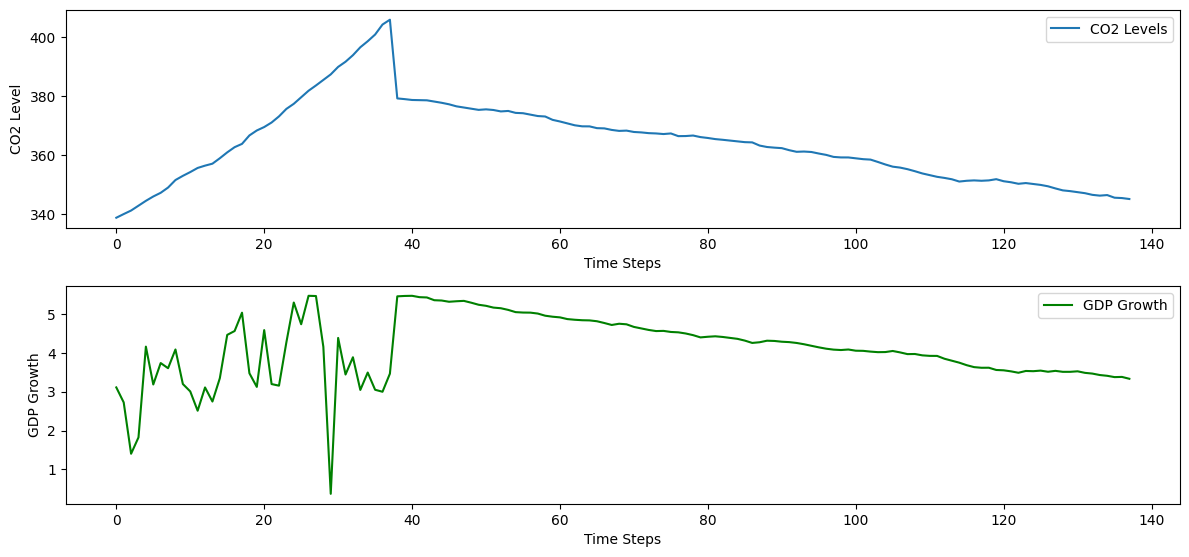

In [15]:
# set plot size
plt.figure(figsize=(12, 8))

# plot CO2 levels
plt.subplot(3, 1, 1)
plt.plot(combined_df.index, combined_df['CO2'], label='CO2 Levels')
plt.xlabel('Time Steps')
plt.ylabel('CO2 Level')
plt.legend()

# plot GDP growth
plt.subplot(3, 1, 2)
plt.plot(combined_df.index, combined_df['GDP_Growth'], label='GDP Growth', color='green')
plt.xlabel('Time Steps')
plt.ylabel('GDP Growth')
plt.legend()

plt.tight_layout()
plt.show()
